## NFL RF and LGMB Models with Raw Player Data and Simple Preprocessing - CRSP metric
In this iteration of the models, we just take the raw next gen player data along with all the game and play level data and see what the model decide is most important to predicting rushing yardage. Obviously with the raw inputs the model will have a hard time of distinguishing the relationships between variables and what features are important. In addition, the model training time will be long as well with so many features. 

**Metric Report:**  
Random Forest Train-Test Split: 0.01377   
Random Forest 3 K-Folds Cross Validation: 0.01382    
LGMB Train-Test Split: 0.01388   
LGMB 3 K-Folds Cross Validation: 0.01393  

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 200
# pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from tqdm import tqdm, tqdm_notebook
import gc

# from kaggle.competitions import nflrush

from NFL_utilsV3 import cleaner,player_features,rusher_features,dropper,player_pivot, crps, create_dataframe
from NFL_play_plotterV2 import cleaner2

import category_encoders as ce

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '/Users/patman/Documents/Kaggle/nfl-big-data-bowl-2020/'
df_train = pd.read_csv('train.csv',low_memory = False,dtype={'WindSpeed':'object'})

## Preprocessing Data
We are using various Pandas operations to clean, standarize and manipulate the data into a useable form. A key aspect was to standarizing the orientation / direction of the play as it could happen in two directions of the field. We standarized where the offense will always move from left to right on the field of play. Thus, the model does not have to learn to account for this arbitary factor. 

In [3]:
%%time
df_train=cleaner2(df_train)

starting.....
abb
Identifiers
Std Orientation
Direction Vector
PlayerHeight
Dtype Change
Scoring
GameClock & Time Elasped
Start Conversion to DateTime
Converted to DateTime
Time Features
Personnel
GameWeather
Wind Speed
Wind Direction
Stadium Type
Turf
Temp & Humidity
Wall time: 1min 1s


In [4]:
Useless_game = ['Stadium','Location','StadiumType','Turf','GameWeather','WindDirection']   #'Temperature','Humidity','WindSpeed'
Game_Attr = ['OffenseFormation','Position','PossessionTeam','DefenseTeam','NflIdRusher','NflId']
cat = df_train[Useless_game+Game_Attr]
cat_single=cat[cat['NflId']==cat['NflIdRusher']]
cat_single.reset_index(inplace=True)
cat_single.drop(['index','NflId','NflIdRusher'],axis=1,inplace=True)

In [5]:
cat_single.head()

,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,OffenseFormation,Position,PossessionTeam,DefenseTeam
0,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SHOTGUN,RB,NE,KC
1,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SHOTGUN,RB,NE,KC
2,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SINGLEBACK,RB,NE,KC
3,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,JUMBO,RB,NE,KC
4,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SHOTGUN,RB,KC,NE


In [6]:
def dropper2(df):
    #Drop columns of least importance (Come back to add them later)
    Standardized = ['X_std','Y_std','Orientation_std','Dir_std','PlayDirection','FieldPosition']
    FE_out = ['HomeScoreBeforePlay','VisitorScoreBeforePlay','OffenseHome','IsOnOffense',
              'PlayerBirthDate','TimeHandoff','TimeSnap']
    Temp_FE = ['OL_diff','OL_TE_diff','run_def']
    Plotting =['ToLeft','YardLine_std','YardLine_grid','dx','dy','A_dx','A_dy']  #'dx','dy',
    Useless_game = ['Stadium','Location','StadiumType','Turf','GameWeather','WindDirection']   #'Temperature','Humidity','WindSpeed'
    Game_Id = ['HomeTeamAbbr','VisitorTeamAbbr','OffDef','TeamOnOffense']
    Game_Attr = ['PossessionTeam','DefenseTeam','NflIdRusher']
    Useless_player = ['Team','JerseyNumber','PlayerCollegeName']
    ID_feature = ['GameId','PlayId','NflId','Season'] #Game Identifiers (treat each play as not connected)
    Player_ID =['DisplayName','IsRusher'] #Player Identifiers
    cat_features = [] #Categorical features (need to come back and encode)
    for col in df.columns:
        if df[col].dtype =='object':
            cat_features.append(col)
#     print('All Cat Features: ',cat_features)
#     cat_features = [cat for cat in cat_features if cat not in Useless_game+Useless_player]
#     print('Remaining Cat: ',cat_features)
    Useless_total = Standardized+FE_out+Plotting+Player_ID+Useless_player+Game_Id+ID_feature+Game_Attr+Useless_game #+Temp_FE
    df.drop(Useless_total,axis=1,inplace =True)
    print('Drop Cols')
    return df

In [7]:
dropper2(df_train);

Drop Cols


In [8]:
df_train.head()

,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,GameClock,Down,Distance,OffenseFormation,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Position,Week,Temperature,Humidity,WindSpeed,OffScoreDiff,TimeElapsed,TimeDelta,PlayerAge,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL
0,73.91,34.84,1.69,1.13,0.40,8.01,272.82,35,1,854.0,3,2,SHOTGUN,6.0,8,72,212,SS,1,63.0,77.0,8.0,0.0,0.766667,1.0,28.692760,2,3,6,1,1,3,1,5
1,74.67,32.64,0.42,1.35,0.01,62.39,251.30,35,1,854.0,3,2,SHOTGUN,6.0,8,75,288,DE,1,63.0,77.0,8.0,0.0,0.766667,1.0,28.457305,2,3,6,1,1,3,1,5
2,74.00,33.20,1.22,0.59,0.31,86.99,247.27,35,1,854.0,3,2,SHOTGUN,6.0,8,75,270,DE,1,63.0,77.0,8.0,0.0,0.766667,1.0,28.629790,2,3,6,1,1,3,1,5
3,71.46,27.70,0.42,0.54,0.02,90.23,344.36,35,1,854.0,3,2,SHOTGUN,6.0,8,75,245,ILB,1,63.0,77.0,8.0,0.0,0.766667,1.0,34.795430,2,3,6,1,1,3,1,5
4,69.32,35.42,1.82,2.43,0.16,77.37,285.69,35,1,854.0,3,2,SHOTGUN,6.0,8,72,206,FS,1,63.0,77.0,8.0,0.0,0.766667,1.0,30.061685,2,3,6,1,1,3,1,5


In [9]:
df_train.drop(['OffenseFormation','Position'],axis=1,inplace=True)

In [10]:
data,all_columns=player_pivot(df_train)

100%|██████████| 23171/23171 [00:45<00:00, 504.52it/s]


In [11]:
df_rusher=pd.DataFrame(data,columns=all_columns)
df_rusher = pd.merge(df_rusher,cat_single,how='left',left_index=True,right_index=True)

In [12]:
df_rusher.head()

,YardLine,Quarter,GameClock,Down,Distance,DefendersInTheBox,Yards,Week,Temperature,Humidity,WindSpeed,OffScoreDiff,TimeElapsed,TimeDelta,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,Y0,Y1,Y2,Y3,Y4,Y5,...,PlayerWeight4,PlayerWeight5,PlayerWeight6,PlayerWeight7,PlayerWeight8,PlayerWeight9,PlayerWeight10,PlayerWeight11,PlayerWeight12,PlayerWeight13,PlayerWeight14,PlayerWeight15,PlayerWeight16,PlayerWeight17,PlayerWeight18,PlayerWeight19,PlayerWeight20,PlayerWeight21,PlayerAge0,PlayerAge1,PlayerAge2,PlayerAge3,PlayerAge4,PlayerAge5,PlayerAge6,PlayerAge7,PlayerAge8,PlayerAge9,PlayerAge10,PlayerAge11,PlayerAge12,PlayerAge13,PlayerAge14,PlayerAge15,PlayerAge16,PlayerAge17,PlayerAge18,PlayerAge19,PlayerAge20,PlayerAge21,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,OffenseFormation,Position,PossessionTeam,DefenseTeam
0,35.0,1.0,854.0,3.0,2.0,6.0,8.0,1.0,63.0,77.0,8.0,0.0,0.766667,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,73.91,74.67,74.00,71.46,69.32,75.06,74.11,73.37,56.63,73.35,74.15,75.82,74.78,75.43,75.90,79.76,76.47,74.70,78.75,74.60,74.58,74.58,34.84,32.64,33.20,27.70,35.42,24.00,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692760,28.457305,28.629790,34.795430,30.061685,26.475101,25.311514,26.431295,27.512746,24.662644,23.184204,31.849502,28.320412,29.341631,29.407339,40.098646,29.875512,23.953540,25.596251,24.030200,25.163670,24.805012,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SHOTGUN,RB,NE,KC
1,43.0,1.0,832.0,1.0,10.0,6.0,3.0,1.0,63.0,77.0,8.0,0.0,1.133333,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,65.73,66.04,66.02,63.31,60.51,66.60,65.12,65.18,48.05,64.46,66.80,70.54,66.75,66.19,67.40,71.79,66.92,67.09,71.07,66.46,67.34,67.91,33.88,30.09,31.50,27.19,26.51,24.27,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692761,28.457306,28.629790,34.795430,30.061686,26.475102,25.311515,26.431296,27.512747,24.662644,23.184205,31.849503,28.320413,29.341631,29.407340,40.098647,29.875512,23.953541,25.596252,24.030201,25.163671,24.805013,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SHOTGUN,RB,NE,KC
2,35.0,1.0,782.0,1.0,10.0,7.0,5.0,1.0,63.0,77.0,8.0,0.0,1.966667,2.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,44.75,44.38,43.39,41.97,40.95,44.63,42.62,39.87,28.24,42.27,44.65,45.12,44.22,44.81,45.24,49.51,43.83,43.36,48.66,43.16,45.46,43.30,26.53,23.42,25.36,19.13,22.46,16.18,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692762,28.457307,28.629792,34.795432,30.061688,26.475103,25.311517,26.431298,27.512749,24.662646,23.184207,31.849504,28.320415,29.341633,29.407341,40.098649,29.875514,23.953543,25.596253,24.030202,25.163673,24.805014,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,SINGLEBACK,RB,NE,KC
3,2.0,1.0,732.0,2.0,2.0,9.0,2.0,1.0,63.0,77.0,8.0,0.0,2.800000,2.0,4.0,4.0,3.0,1.0,2.0,0.0,2.0,6.0,11.91,9.67,11.28,11.17,9.76,10.87,10.32,11.13,10.06,9.20,12.21,11.18,10.92,11.56,16.30,12.64,11.76,11.47,15.53,11.49,10.29,11.95,22.64,18.48,27.79,29.14,25.49,20.32,...,245.0,254.0,206.0,315.0,237.0,197.0,307.0,265.0,335.0,325.0,225.0,255.0,260.0,315.0,210.0,310.0,300.0,308.0,30.168470,28.692769,28.457314,28.629798,34.795438,30.513440,30.061694,27.696191,25.054165,24.662652,24.183529,28.320421,29.341639,29.407348,40.098655,29.128087,27.537396,26.135616,26.852933,24.030209,25.163679,24.805021,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,south_west,JUMBO,RB,NE,KC
4,25.0,1.0,728.0,1.0,10.0,7.0,7.0,1.0,63.0,77.0,8.0,-7.0,2.866667,1.0,3.0,2.0,6.0,1.0,1.0,1.0,3.0,5.0,29.51,33.19,33.34,31.36,34.25,33.61,35.07,36.19,34.18,33.80,29.99,35.70,49.41,34.47,33.95,37.61,47.72,36.52,39.79,34.33,38.80,34.25,27.27,22.01,27.69,34.73,35.99,23.61,...,230.0,321.0,320.0,205.0,305.0,248.0,216.0,215.0,195.0,350.0

In [13]:
# df_rusher = pd.read_csv('All_raw_player.csv',index_col=0)

In [14]:
encoder ='TE'

cat_features = []
dense_features = []
for col in df_rusher.columns:
    if df_rusher[col].dtype =='object':
        cat_features.append(col)
#         print("*cat*", col, len(df_rusher[col].unique()))
    else:
        dense_features.append(col)
#         print("!dense!", col, len(df_rusher[col].unique()))
dense_features.remove("Yards")
#### Cat
train_cat = df_rusher[cat_features]
categories = []
most_appear_each_categories = {}
for col in tqdm(train_cat.columns):
    train_cat.loc[:,col] = train_cat[col].fillna("nan")
    train_cat.loc[:,col] = col + "__" + train_cat[col].astype(str)
    most_appear_each_categories[col] = list(train_cat[col].value_counts().index)[0]
    categories.append(train_cat[col].unique())
categories = np.hstack(categories)

# print(len(categories))

OH=OneHotEncoder(sparse=False)
le = LabelEncoder()
TE = ce.TargetEncoder()
if encoder =='le':
    le.fit(categories)
    for col in tqdm(train_cat.columns):
        train_cat.loc[:, col] = le.transform(train_cat[col])
        num_classes = len(le.classes_)
elif encoder == 'OH':
    OH.fit(train_cat)
    train_cat = pd.DataFrame(OH.transform(train_cat),columns=categories)
elif encoder == "TE":
    TE.fit(train_cat,df_rusher['Yards'])
    train_cat = pd.DataFrame(TE.transform(train_cat),columns=cat_features)
#### Dense
train_dense = df_rusher[dense_features]
sss = {}
medians = {}
for col in tqdm(train_dense.columns):
#         print(col)
    medians[col] = np.nanmedian(train_dense[col])
    train_dense.loc[:, col] = train_dense[col].fillna(medians[col])
#     ss = StandardScaler()
#     train_dense.loc[:, col] = ss.fit_transform(train_dense[col].values[:,None])
#     sss[col] = ss

df_final = train_dense.merge(train_cat, how='outer', left_index=True, right_index=True)

100%|██████████| 241/241 [00:07<00:00, 32.89it/s]


In [15]:
cat_features

['Stadium',
 'Location',
 'StadiumType',
 'Turf',
 'GameWeather',
 'WindDirection',
 'OffenseFormation',
 'Position',
 'PossessionTeam',
 'DefenseTeam']

In [16]:
X=df_final
yards = df_rusher['Yards'].astype('int')
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [17]:
X.head()

,YardLine,Quarter,GameClock,Down,Distance,DefendersInTheBox,Week,Temperature,Humidity,WindSpeed,OffScoreDiff,TimeElapsed,TimeDelta,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,Y0,Y1,Y2,Y3,Y4,Y5,Y6,...,PlayerWeight4,PlayerWeight5,PlayerWeight6,PlayerWeight7,PlayerWeight8,PlayerWeight9,PlayerWeight10,PlayerWeight11,PlayerWeight12,PlayerWeight13,PlayerWeight14,PlayerWeight15,PlayerWeight16,PlayerWeight17,PlayerWeight18,PlayerWeight19,PlayerWeight20,PlayerWeight21,PlayerAge0,PlayerAge1,PlayerAge2,PlayerAge3,PlayerAge4,PlayerAge5,PlayerAge6,PlayerAge7,PlayerAge8,PlayerAge9,PlayerAge10,PlayerAge11,PlayerAge12,PlayerAge13,PlayerAge14,PlayerAge15,PlayerAge16,PlayerAge17,PlayerAge18,PlayerAge19,PlayerAge20,PlayerAge21,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,OffenseFormation,Position,PossessionTeam,DefenseTeam
0,35.0,1.0,854.0,3.0,2.0,6.0,1.0,63.0,77.0,8.0,0.0,0.766667,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,73.91,74.67,74.00,71.46,69.32,75.06,74.11,73.37,56.63,73.35,74.15,75.82,74.78,75.43,75.90,79.76,76.47,74.70,78.75,74.60,74.58,74.58,34.84,32.64,33.20,27.70,35.42,24.00,16.64,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692760,28.457305,28.629790,34.795430,30.061685,26.475101,25.311514,26.431295,27.512746,24.662644,23.184204,31.849502,28.320412,29.341631,29.407339,40.098646,29.875512,23.953540,25.596251,24.030200,25.163670,24.805012,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.508161,4.172739,4.489412,4.561198
1,43.0,1.0,832.0,1.0,10.0,6.0,1.0,63.0,77.0,8.0,0.0,1.133333,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,65.73,66.04,66.02,63.31,60.51,66.60,65.12,65.18,48.05,64.46,66.80,70.54,66.75,66.19,67.40,71.79,66.92,67.09,71.07,66.46,67.34,67.91,33.88,30.09,31.50,27.19,26.51,24.27,9.43,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692761,28.457306,28.629790,34.795430,30.061686,26.475102,25.311515,26.431296,27.512747,24.662644,23.184205,31.849503,28.320413,29.341631,29.407340,40.098647,29.875512,23.953541,25.596252,24.030201,25.163671,24.805013,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.508161,4.172739,4.489412,4.561198
2,35.0,1.0,782.0,1.0,10.0,7.0,1.0,63.0,77.0,8.0,0.0,1.966667,2.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,44.75,44.38,43.39,41.97,40.95,44.63,42.62,39.87,28.24,42.27,44.65,45.12,44.22,44.81,45.24,49.51,43.83,43.36,48.66,43.16,45.46,43.30,26.53,23.42,25.36,19.13,22.46,16.18,9.08,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692762,28.457307,28.629792,34.795432,30.061688,26.475103,25.311517,26.431298,27.512749,24.662646,23.184207,31.849504,28.320415,29.341633,29.407341,40.098649,29.875514,23.953543,25.596253,24.030202,25.163673,24.805014,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.222114,4.172739,4.489412,4.561198
3,2.0,1.0,732.0,2.0,2.0,9.0,1.0,63.0,77.0,8.0,0.0,2.800000,2.0,4.0,4.0,3.0,1.0,2.0,0.0,2.0,6.0,11.91,9.67,11.28,11.17,9.76,10.87,10.32,11.13,10.06,9.20,12.21,11.18,10.92,11.56,16.30,12.64,11.76,11.47,15.53,11.49,10.29,11.95,22.64,18.48,27.79,29.14,25.49,20.32,33.65,...,245.0,254.0,206.0,315.0,237.0,197.0,307.0,265.0,335.0,325.0,225.0,255.0,260.0,315.0,210.0,310.0,300.0,308.0,30.168470,28.692769,28.457314,28.629798,34.795438,30.513440,30.061694,27.696191,25.054165,24.662652,24.183529,28.320421,29.341639,29.407348,40.098655,29.128087,27.537396,26.135616,26.852933,24.030209,25.163679,24.805021,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,1.756238,4.172739,4.489412,4.561198
4,25.0,1.0,728.0,1.0,10.0,7.0,1.0,63.0,77.0,8.0,-7.0,2.866667,1.0,3.0,2.0,6.0,1.0,1.0,1.0,3.0,5.0,29.51,33.19,33.34,31.36,34.25,33.61,35.07,36.19,34.18,33.80,29.99,35.70,49.41,34.47,33.95,37.61,47.72,36.52,39.79,34.33,38.80,34.25,27.27,22.01,27.69,34.73,35.99,23.61,26.40,...,230.0,321.0,320.0,205.0,305.0,248.0,216

In [18]:
# sns.set(rc={'figure.figsize':(30, 30)})
# corr = X.corr()
# plt.figure() 
# ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
# plt.savefig('corr_heatmap.png')
# plt.show()

In [19]:
# # Drop highly correlated features (37->28)
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.99:
#             if columns[j]:
#                 columns[j] = False

# feature_columns = X.columns[columns].values
# drop_columns = X.columns[columns == False].values
# print(feature_columns)
# print(len(feature_columns))
# print(drop_columns)
# print(len(drop_columns))

## Random Forest Model

### Train-Test Split RF Model

In [20]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, min_samples_split=7, n_estimators=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
AE_,score1_ = crps(y_test,y_pred)

Wall time: 44.5 s


In [21]:
print('CRPS: ',score1_)
print('MAE:',AE_.mean())

CRPS:  0.013760655277357542
MAE: 2.738370400194151


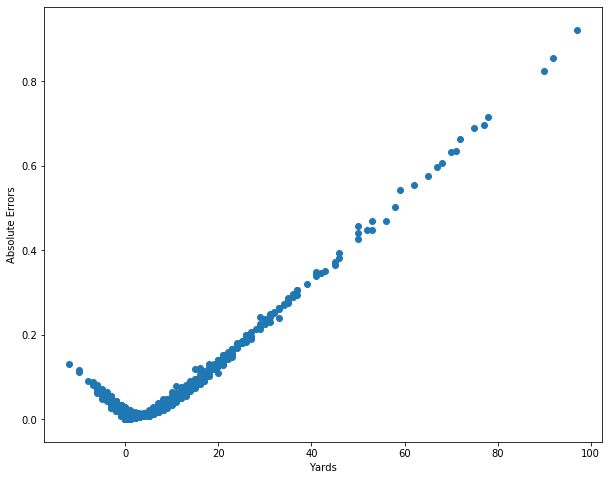

In [22]:
yards_test=[]
for i in range(len(y_test)):
    index =np.argmax(y_test[i])
    yard =index-99
    yards_test.append(yard)
    
yards_test=np.asarray(yards_test)
    
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_/100)
# plt.plot(y_test, y_test, color='orange')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.show()

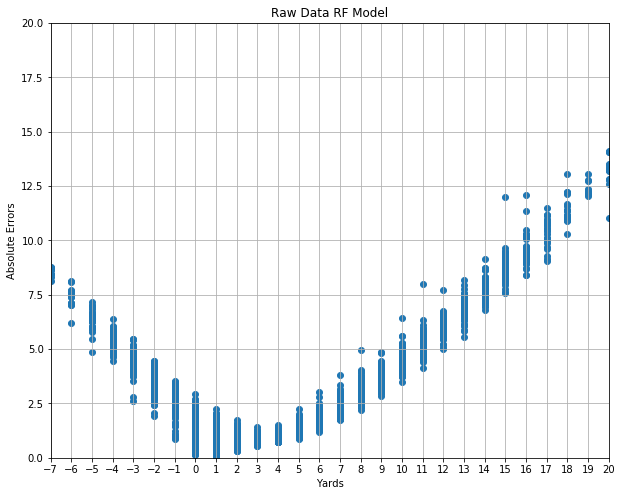

In [23]:
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
plt.title('Raw Data RF Model')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.xticks(np.arange(min(yards_test), max(yards_test)+1, 1.0))
plt.xlim((-7,20))
plt.ylim((0,20))
plt.grid()
# plt.savefig(f'Raw_RF_AE.png')
plt.show()

In [24]:
feature_import_RF =model.feature_importances_
features_RF = X.columns.T
RF_feat_df = pd.DataFrame({'Features': features_RF,
                        'Importances': feature_import_RF})

In [25]:
RF_feat_df.sort_values('Importances',ascending=False).head(10)

,Features,Importances
0,YardLine,0.019442
4,Distance,0.012886
5,DefendersInTheBox,0.006860
248,Position,0.006182
94,A7,0.006082
64,Y21,0.005969
11,TimeElapsed,0.005943
240,PlayerAge21,0.005850
82,S17,0.005836
75,S10,0.005767


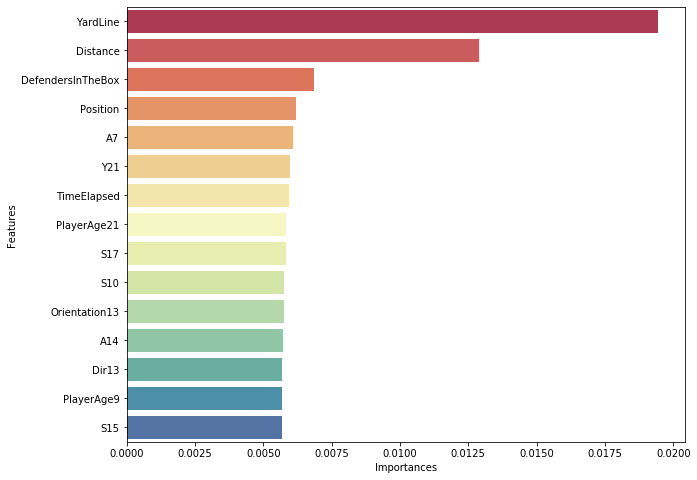

In [26]:
plt.figure(figsize=(10,8))
sns.barplot(x='Importances',y='Features',data=RF_feat_df.sort_values(by='Importances',ascending=False).head(15),palette='Spectral')
# plt.savefig(f'Raw_RF_FeatureImportances.png',bbox_inches="tight")

In [27]:
#Feature Selection Methods
# fs_ = SelectFromModel(model, prefit=True)
# X.shape
# fs_.transform(X).shape

# feature_idx = fs_.get_support()
# feature_name = X.columns[feature_idx]
# print(feature_name)

### Cross-Validation RF Model (3 K-Folds)

In [28]:
X=df_final
yards = df_rusher['Yards'].astype('int')
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [29]:
kf = KFold(n_splits=3, random_state=42)
scores_RF = []
MAE_RF = []
models_RF=[]
for i, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'Fold : {i}')
    X_train, X_val, y_train, y_val = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, min_samples_split=7, n_estimators=50, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    AE_,score_ = crps(y_val, model.predict(X_val))
    print('CRPS: ',score_)
    print('MAE:',AE_.mean())
    scores_RF.append(score_)
    models_RF.append(model)
    MAE_RF.append(AE_.mean())


Fold : 0
CRPS:  0.013663038131575444
MAE: 2.7189445881835135
Fold : 1
CRPS:  0.013392149451185468
MAE: 2.6650377407859085
Fold : 2
CRPS:  0.014412691972743138
MAE: 2.868125702575884


In [30]:
print('Avg CRPS: ',np.mean(scores_RF))
print('Avg MAE: ',np.mean(MAE_RF))

Avg CRPS:  0.013822626518501349
Avg MAE:  2.750702677181769


In [31]:
feature_import_RF_0 =models_RF[0].feature_importances_
feature_import_RF_1 =models_RF[1].feature_importances_
feature_import_RF_2 =models_RF[2].feature_importances_
# feature_import_RF_3 =models_RF[3].feature_importances_
# feature_import_RF_4 =models_RF[4].feature_importances_
features_RF = X.columns.T
RF_feat_df2 = pd.DataFrame({'Features': features_RF,
                        'Importances_0': feature_import_RF_0,
                        'Importances_1': feature_import_RF_1,
                        'Importances_2': feature_import_RF_2})   #'Importances_3': feature_import_RF_3,'Importances_4': feature_import_RF_4
RF_feat_df2['average'] = RF_feat_df2[[f'Importances_{i}' for i in range(3)]].mean(axis=1)
RF_feat_df2.sort_values('average',ascending=False).head(10)

,Features,Importances_0,Importances_1,Importances_2,average
0,YardLine,0.023672,0.020945,0.020878,0.021832
4,Distance,0.011598,0.013197,0.011465,0.012087
5,DefendersInTheBox,0.006985,0.007615,0.008786,0.007795
11,TimeElapsed,0.005314,0.006732,0.006732,0.006259
81,S16,0.006712,0.005341,0.005892,0.005982
248,Position,0.006163,0.003980,0.007675,0.005940
82,S17,0.005855,0.004632,0.006577,0.005688
54,Y11,0.005085,0.005618,0.006157,0.005620
63,Y20,0.006006,0.005620,0.005155,0.005594
64,Y21,0.005773,0.005817,0.005124,0.005571


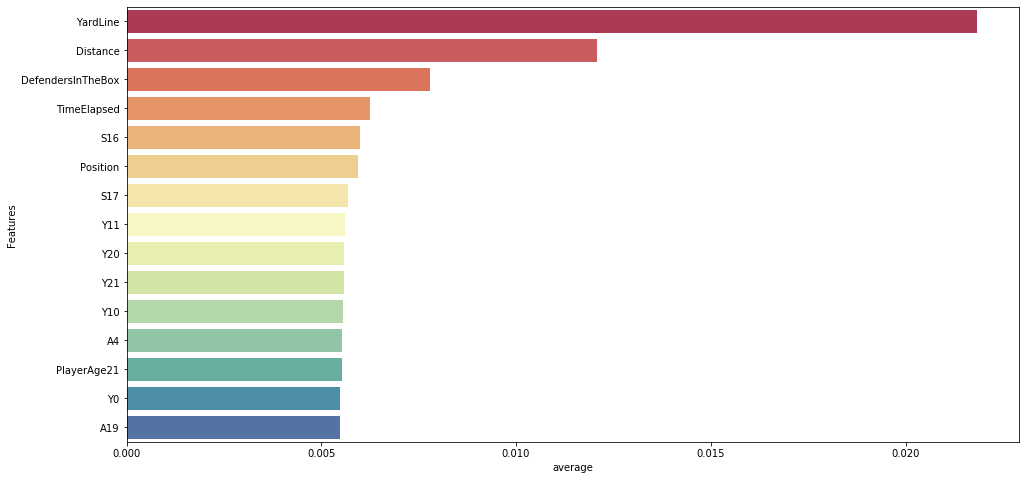

In [32]:
plt.figure(figsize=(16,8))
sns.barplot(x='average',y='Features',data=RF_feat_df2.sort_values(by='average',ascending=False).head(15),palette='Spectral')
# plt.savefig(f'Raw_RF_FeatureImportances_CV.png')

In [33]:
# # If we had yards for holdout set
# df_test = create_dataframe(df_holdout)
# #### Cat
# train_cat_test = df_test[cat_features]
# for col in tqdm_notebook(train_cat_test.columns):
#     train_cat_test.loc[:,col] = train_cat_test[col].fillna("nan")
#     train_cat_test.loc[:,col] = col + "__" + train_cat_test[col].astype(str)

# if encoder =='le':
#     for col in tqdm_notebook(train_cat.columns):
#         train_cat_test.loc[:, col] = le.transform(train_cat_test[col])

# elif encoder == 'OH':
#     train_cat_test = pd.DataFrame(OH.transform(train_cat_test),columns=categories)
# elif encoder =='TE':
#     train_cat_test = pd.DataFrame(TE.transform(train_cat_test),columns=cat_features)
# #### Dense
# train_dense_test = df_test[dense_features]
# for col in tqdm_notebook(train_dense_test.columns):
#     train_dense_test.loc[:, col] = train_dense_test[col].fillna(medians[col])
#     train_dense_test.loc[:, col] = sss[col].transform(train_dense_test[col].values[:,None])
# ###
# df_final_test = train_dense_test.merge(train_cat_test, how='outer', left_index=True, right_index=True)

# y_pred2 = model.predict(df_final_test)


## LGB Model

### Train-Test Split LGBM

In [34]:
X=df_final
yards = df_rusher['Yards'].astype('int')
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [35]:
metric = "multi_logloss"
param = {'num_leaves': 50, #Original 50
         'min_data_in_leaf': 30, #Original 30
         'objective':'multiclass',
         'num_class': 199, # 199 possible places
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7, #0.9
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": metric,
         "lambda_l1": 0.1,
         "verbosity": -1,
         "seed":1234}

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_valid=y_test
y_train=np.argmax(y_train,axis=1)
y_test=np.argmax(y_test,axis=1)
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test)
num_round = 10000
model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
AE_,score_ = crps(y_valid, model.predict(X_test, num_iteration=model.best_iteration))
print('CRPS: ',score_)
print('MAE:',AE_.mean())

Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.09766	valid_1's multi_logloss: 2.88453
[200]	training's multi_logloss: 1.7169	valid_1's multi_logloss: 2.88257
[300]	training's multi_logloss: 1.45089	valid_1's multi_logloss: 2.89368
Early stopping, best iteration is:
[160]	training's multi_logloss: 1.84997	valid_1's multi_logloss: 2.88121
CRPS:  0.013878275478385755
MAE: 2.761776820198765


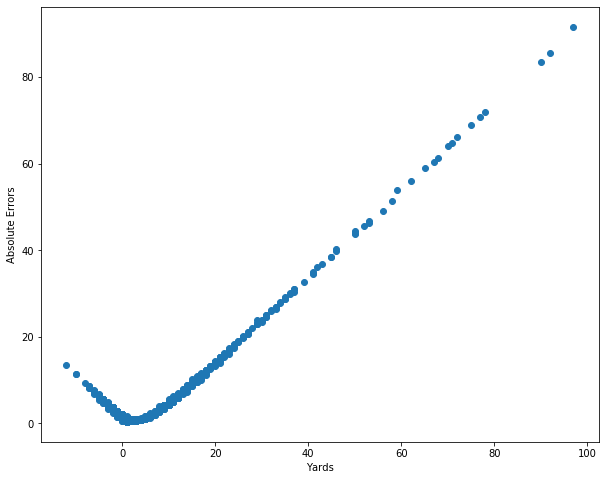

In [36]:
yards_test=[]
for i in range(len(y_valid)):
    index =np.argmax(y_valid[i])
    yard =index-99
    yards_test.append(yard)
    
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
# plt.plot(y_test, y_test, color='orange')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.show()

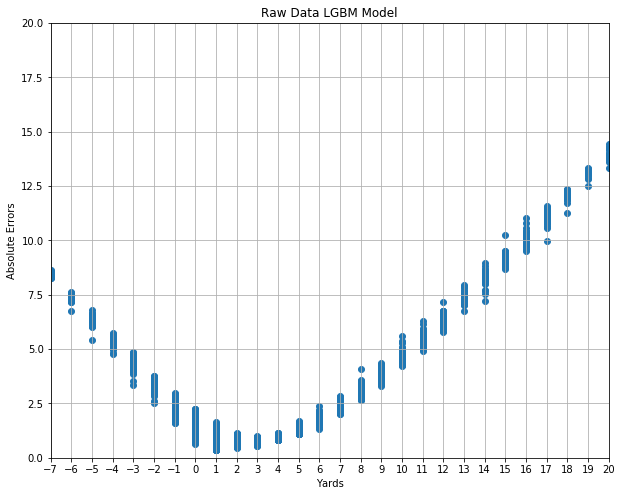

In [37]:
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
plt.title('Raw Data LGBM Model')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.xticks(np.arange(min(yards_test), max(yards_test)+1, 1.0))
plt.xlim((-7,20))
plt.ylim((0,20))
plt.grid()
# plt.savefig(f'Raw_LGBM_AE.png')
plt.show()

In [38]:
feature_importance_df=pd.DataFrame()
feature_importance_df["Feature"] = X.columns
feature_importance_df[f"Importance Split"] = model.feature_importance(importance_type='split')
feature_importance_df[f'Importance Gain'] =  model.feature_importance(importance_type='gain')

In [39]:
feature_importance_df.sort_values('Importance Gain',ascending=False).head(10)

,Feature,Importance Split,Importance Gain
0,YardLine,2551,29066.302581
4,Distance,1211,14409.968084
2,GameClock,1706,12458.695676
108,A21,1946,12037.660797
93,A6,1721,11302.880634
44,Y1,1495,10873.922020
53,Y10,1574,10851.642302
61,Y18,1697,10810.315924
11,TimeElapsed,1672,10808.072101
102,A15,1705,10675.015145


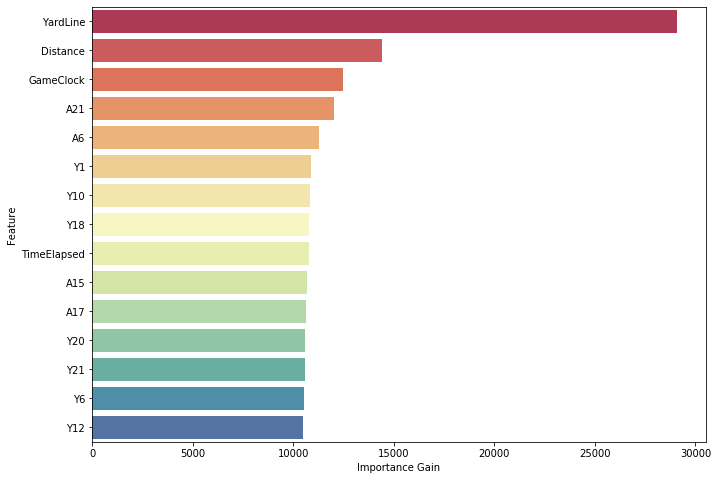

In [40]:
plt.figure(figsize=(11,8))
sns.barplot(x='Importance Gain',y='Feature',data=feature_importance_df.sort_values(by='Importance Gain',ascending=False).head(15),palette='Spectral')
# plt.savefig(f'Raw_LGBM_FeatureImportances.png',bbox_inches="tight")

In [41]:
# lgb.plot_importance(model, importance_type='split',max_num_features=40,figsize=(15,8))

In [42]:
# lgb.plot_importance(model, importance_type='gain',max_num_features=40,figsize=(15,8))

### Cross-Validation LGBM (3 K-Folds)

In [43]:
X=df_final
yards = df_rusher['Yards'].astype('int')
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [44]:
X.head()

,YardLine,Quarter,GameClock,Down,Distance,DefendersInTheBox,Week,Temperature,Humidity,WindSpeed,OffScoreDiff,TimeElapsed,TimeDelta,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,Y0,Y1,Y2,Y3,Y4,Y5,Y6,...,PlayerWeight4,PlayerWeight5,PlayerWeight6,PlayerWeight7,PlayerWeight8,PlayerWeight9,PlayerWeight10,PlayerWeight11,PlayerWeight12,PlayerWeight13,PlayerWeight14,PlayerWeight15,PlayerWeight16,PlayerWeight17,PlayerWeight18,PlayerWeight19,PlayerWeight20,PlayerWeight21,PlayerAge0,PlayerAge1,PlayerAge2,PlayerAge3,PlayerAge4,PlayerAge5,PlayerAge6,PlayerAge7,PlayerAge8,PlayerAge9,PlayerAge10,PlayerAge11,PlayerAge12,PlayerAge13,PlayerAge14,PlayerAge15,PlayerAge16,PlayerAge17,PlayerAge18,PlayerAge19,PlayerAge20,PlayerAge21,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,OffenseFormation,Position,PossessionTeam,DefenseTeam
0,35.0,1.0,854.0,3.0,2.0,6.0,1.0,63.0,77.0,8.0,0.0,0.766667,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,73.91,74.67,74.00,71.46,69.32,75.06,74.11,73.37,56.63,73.35,74.15,75.82,74.78,75.43,75.90,79.76,76.47,74.70,78.75,74.60,74.58,74.58,34.84,32.64,33.20,27.70,35.42,24.00,16.64,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692760,28.457305,28.629790,34.795430,30.061685,26.475101,25.311514,26.431295,27.512746,24.662644,23.184204,31.849502,28.320412,29.341631,29.407339,40.098646,29.875512,23.953540,25.596251,24.030200,25.163670,24.805012,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.508161,4.172739,4.489412,4.561198
1,43.0,1.0,832.0,1.0,10.0,6.0,1.0,63.0,77.0,8.0,0.0,1.133333,1.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,65.73,66.04,66.02,63.31,60.51,66.60,65.12,65.18,48.05,64.46,66.80,70.54,66.75,66.19,67.40,71.79,66.92,67.09,71.07,66.46,67.34,67.91,33.88,30.09,31.50,27.19,26.51,24.27,9.43,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692761,28.457306,28.629790,34.795430,30.061686,26.475102,25.311515,26.431296,27.512747,24.662644,23.184205,31.849503,28.320413,29.341631,29.407340,40.098647,29.875512,23.953541,25.596252,24.030201,25.163671,24.805013,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.508161,4.172739,4.489412,4.561198
2,35.0,1.0,782.0,1.0,10.0,7.0,1.0,63.0,77.0,8.0,0.0,1.966667,2.0,2.0,3.0,6.0,1.0,1.0,3.0,1.0,5.0,44.75,44.38,43.39,41.97,40.95,44.63,42.62,39.87,28.24,42.27,44.65,45.12,44.22,44.81,45.24,49.51,43.83,43.36,48.66,43.16,45.46,43.30,26.53,23.42,25.36,19.13,22.46,16.18,9.08,...,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,28.692762,28.457307,28.629792,34.795432,30.061688,26.475103,25.311517,26.431298,27.512749,24.662646,23.184207,31.849504,28.320415,29.341633,29.407341,40.098649,29.875514,23.953543,25.596253,24.030202,25.163673,24.805014,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.222114,4.172739,4.489412,4.561198
3,2.0,1.0,732.0,2.0,2.0,9.0,1.0,63.0,77.0,8.0,0.0,2.800000,2.0,4.0,4.0,3.0,1.0,2.0,0.0,2.0,6.0,11.91,9.67,11.28,11.17,9.76,10.87,10.32,11.13,10.06,9.20,12.21,11.18,10.92,11.56,16.30,12.64,11.76,11.47,15.53,11.49,10.29,11.95,22.64,18.48,27.79,29.14,25.49,20.32,33.65,...,245.0,254.0,206.0,315.0,237.0,197.0,307.0,265.0,335.0,325.0,225.0,255.0,260.0,315.0,210.0,310.0,300.0,308.0,30.168470,28.692769,28.457314,28.629798,34.795438,30.513440,30.061694,27.696191,25.054165,24.662652,24.183529,28.320421,29.341639,29.407348,40.098655,29.128087,27.537396,26.135616,26.852933,24.030209,25.163679,24.805021,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,1.756238,4.172739,4.489412,4.561198
4,25.0,1.0,728.0,1.0,10.0,7.0,1.0,63.0,77.0,8.0,-7.0,2.866667,1.0,3.0,2.0,6.0,1.0,1.0,1.0,3.0,5.0,29.51,33.19,33.34,31.36,34.25,33.61,35.07,36.19,34.18,33.80,29.99,35.70,49.41,34.47,33.95,37.61,47.72,36.52,39.79,34.33,38.80,34.25,27.27,22.01,27.69,34.73,35.99,23.61,26.40,...,230.0,321.0,320.0,205.0,305.0,248.0,216

In [45]:
metric = "multi_logloss"
param = {'num_leaves': 50, #Original 50
         'min_data_in_leaf': 30, #Original 30
         'objective':'multiclass',
         'num_class': 199, # 199 possible places
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7, #0.9
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": metric,
         "lambda_l1": 0.1,
         "verbosity": -1,
         "seed":1234}

models = []
kf = KFold(n_splits=3, random_state=42)
score = []
MAE = []
feature_importance_df2 = pd.DataFrame()
X_columns=X.columns.values.tolist()
best_validation_scores = []
# y = np.argmax(y, axis=1)

for i, (tdx, vdx) in tqdm(enumerate(kf.split(X, y))):
    print(f'Fold : {i}')
    X_train, X_val, y_train, y_val = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    y_valid=y_val
    y_train=np.argmax(y_train,axis=1)
    y_val=np.argmax(y_val,axis=1)
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    num_round = 10000
    model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    AE_,score_ = crps(y_valid, model.predict(X_val, num_iteration=model.best_iteration))
#     score_ = crps(np.expand_dims(y_val, axis=1), model.predict(X_val, num_iteration=model.best_iteration))
    print('CRPS: ',score_)
    print('MAE:',AE_.mean())
#     feature_importance[ i, :] = model.feature_importance()
#     fold_importance_df = pd.DataFrame()
    feature_importance_df2["feature"] = X_columns
    feature_importance_df2[f"importance_{i}"] = model.feature_importance(importance_type='gain')

#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    best_validation_scores.append(model.best_score['valid_1'][metric])
    score.append(score_)
    MAE.append(AE_.mean())
    models.append(model)
print('Avg CRPS: ',np.mean(scores_RF))
print('Avg MAE: ',np.mean(MAE_RF))


0it [00:00, ?it/s]

Fold : 0
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.06048	valid_1's multi_logloss: 2.86403
[200]	training's multi_logloss: 1.65958	valid_1's multi_logloss: 2.86473
[300]	training's multi_logloss: 1.38313	valid_1's multi_logloss: 2.87757
Early stopping, best iteration is:
[140]	training's multi_logloss: 1.87848	valid_1's multi_logloss: 2.86214
CRPS:  0.013721451161384277
MAE: 2.730568781115471


1it [03:48, 228.13s/it]

Fold : 1
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.06087	valid_1's multi_logloss: 2.86816
[200]	training's multi_logloss: 1.66044	valid_1's multi_logloss: 2.8682
[300]	training's multi_logloss: 1.38473	valid_1's multi_logloss: 2.88097
Early stopping, best iteration is:
[150]	training's multi_logloss: 1.8387	valid_1's multi_logloss: 2.86616
CRPS:  0.013501290737370112
MAE: 2.686756856736652


2it [06:59, 217.04s/it]

Fold : 2
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.05931	valid_1's multi_logloss: 2.92001
[200]	training's multi_logloss: 1.66413	valid_1's multi_logloss: 2.92415
[300]	training's multi_logloss: 1.39032	valid_1's multi_logloss: 2.94019
Early stopping, best iteration is:
[133]	training's multi_logloss: 1.90837	valid_1's multi_logloss: 2.91938
CRPS:  0.014568151311725085
MAE: 2.899062111033292


3it [09:40, 200.25s/it]


Avg CRPS:  0.013822626518501349
Avg MAE:  2.750702677181769


In [46]:
feature_importance_df2['average'] = feature_importance_df2[[f'importance_{i}' for i in range(3)]].mean(axis=1)
feature_importance_df2.sort_values('average',ascending=False).head(20)

,feature,importance_0,importance_1,importance_2,average
0,YardLine,29613.916275,24935.054514,22198.153888,25582.374893
4,Distance,12703.494292,12607.474144,11107.803522,12139.590653
108,A21,10347.524156,9337.896887,10849.026848,10178.149297
64,Y21,9411.064800,10569.419063,9010.514176,9663.666013
61,Y18,10362.871182,8506.931457,9891.815922,9587.206187
53,Y10,9467.688204,10264.142968,8791.625253,9507.818808
96,A9,9606.009470,9274.606254,9342.677825,9407.764516
103,A16,8996.725281,10283.778707,8704.997723,9328.500570
2,GameClock,9302.885780,10162.241780,8478.367114,9314.498225
45,Y2,9074.864013,10041.836553,8664.625127,9260.441898


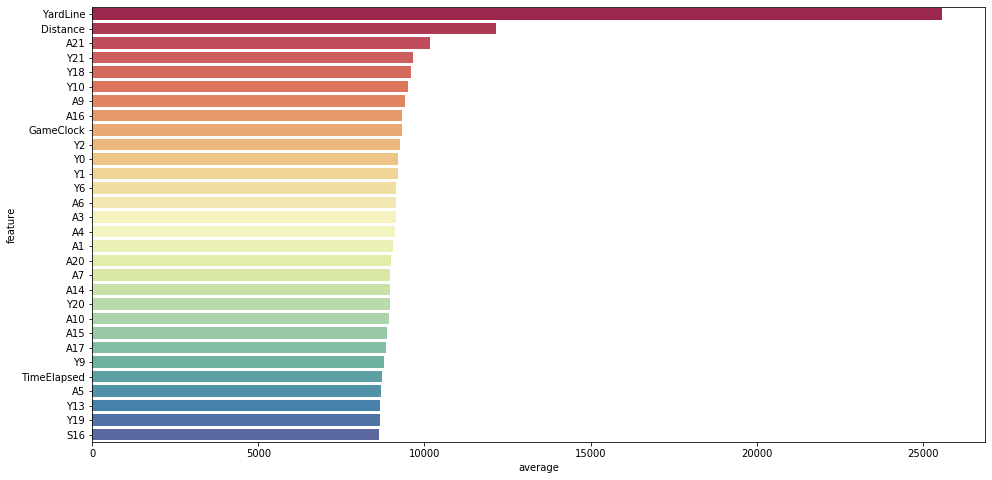

In [47]:
plt.figure(figsize=(16,8))
sns.barplot(x='average',y='feature',data=feature_importance_df2.sort_values(by='average',ascending=False).head(30),palette='Spectral')